## VGG Models

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim
from tqdm import tqdm

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


### Data Preparation

In [3]:
class VehicleDataset(Dataset):
    
    def __init__(self, path):
        data = np.load(path)
        self.images = data["images"]
        self.labels = data["labels"]
        print("Images shape:", self.images.shape)
        print("Labels shape:", self.labels.shape)
        self.__combinelabels__()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(label, dtype=torch.long)

        #mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        #std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        #image = (image - mean) / std
        
        return image, label
    def __combinelabels__(self):
        for idx, label in enumerate(self.labels):
            if label == 1:
                self.labels[idx] = 1
            if label >= 2 and label <= 7:
                self.labels[idx] = 2
            if label >= 8 and label <= 11:
                self.labels[idx] = 3
            if label >= 12 and label <= 25:
                self.labels[idx] = 4
            if label >= 26 and label <= 38:
               self.labels[idx] = 5
            if label >= 39 and label <= 44:
                self.labels[idx] = 6
            if label >= 45 and label <= 50:
                self.labels[idx] = 7
            if label >= 51 and label <= 53:
                self.labels[idx] = 8
            if label >= 54 and label <= 75:
                self.labels[idx] = 9
            if label >= 76 and label <= 81:
                self.labels[idx] = 10
            if label == 82:
                self.labels[idx] = 11
            if label >= 83 and label <= 97:
                self.labels[idx] = 12
            if label == 98:
                self.labels[idx] = 13
            if label >= 99 and label <= 100:
                self.labels[idx] = 14
            if label >= 101 and label <= 104:
                self.labels[idx] = 15
            if label == 105:
                self.labels[idx] = 16
            if label >= 106 and label <= 117:
                self.labels[idx] = 17
            if label >= 118 and label <= 122:
                self.labels[idx] = 18
            if label == 123:
                self.labels[idx] = 19
            if label >= 124 and label <= 125:
                self.labels[idx] = 20
            if label >= 126 and label <= 129:
                self.labels[idx] = 21
            if label >= 130 and label <= 140:
                self.labels[idx] = 22
            if label >= 141 and label <= 142:
                self.labels[idx] = 23
            if label == 143:
                self.labels[idx] = 24
            if label == 144:
                self.labels[idx] = 25
            if label >= 145 and label <= 149:
                self.labels[idx] = 26
            if label >= 150 and label <= 153:
                self.labels[idx] = 27
            if label >= 154 and label <= 155:
                self.labels[idx] = 28
            if label == 156:
                self.labels[idx] = 29
            if label == 157:
                self.labels[idx] = 30
            if label == 158:
                self.labels[idx] = 31
            if label == 159:
                self.labels[idx] = 32
            if label == 160:
                self.labels[idx] = 33
            if label >= 161 and label <= 166:
                self.labels[idx] = 34
            if label == 167:
                self.labels[idx] = 35
            if label >= 168 and label <= 171:
                self.labels[idx] = 36
            if label == 172:
                self.labels[idx] = 37
            if label == 173:
                self.labels[idx] = 38
            if label == 174:
                self.labels[idx] = 39
            if label >= 175 and label <= 177:
                self.labels[idx] = 40
            if label == 178:
                self.labels[idx] = 41
            if label >= 179 and label <= 180:
                self.labels[idx] = 42
            if label >= 181 and label <= 184:
                self.labels[idx] = 43
            if label == 185:
                self.labels[idx] = 44
            if label >= 186 and label <= 189:
                self.labels[idx] = 45
            if label >= 190 and label <= 192:
                self.labels[idx] = 46
            if label >= 193 and label <= 195:
                self.labels[idx] = 47
            if label == 196:
                self.labels[idx] = 48

In [4]:
dataset = VehicleDataset('../dataset/stanford_cars_dataset.npz')

batch_size = 32
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = int(len(dataset) - train_size - val_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Images shape: (8144, 112, 112, 3)
Labels shape: (8144, 1)


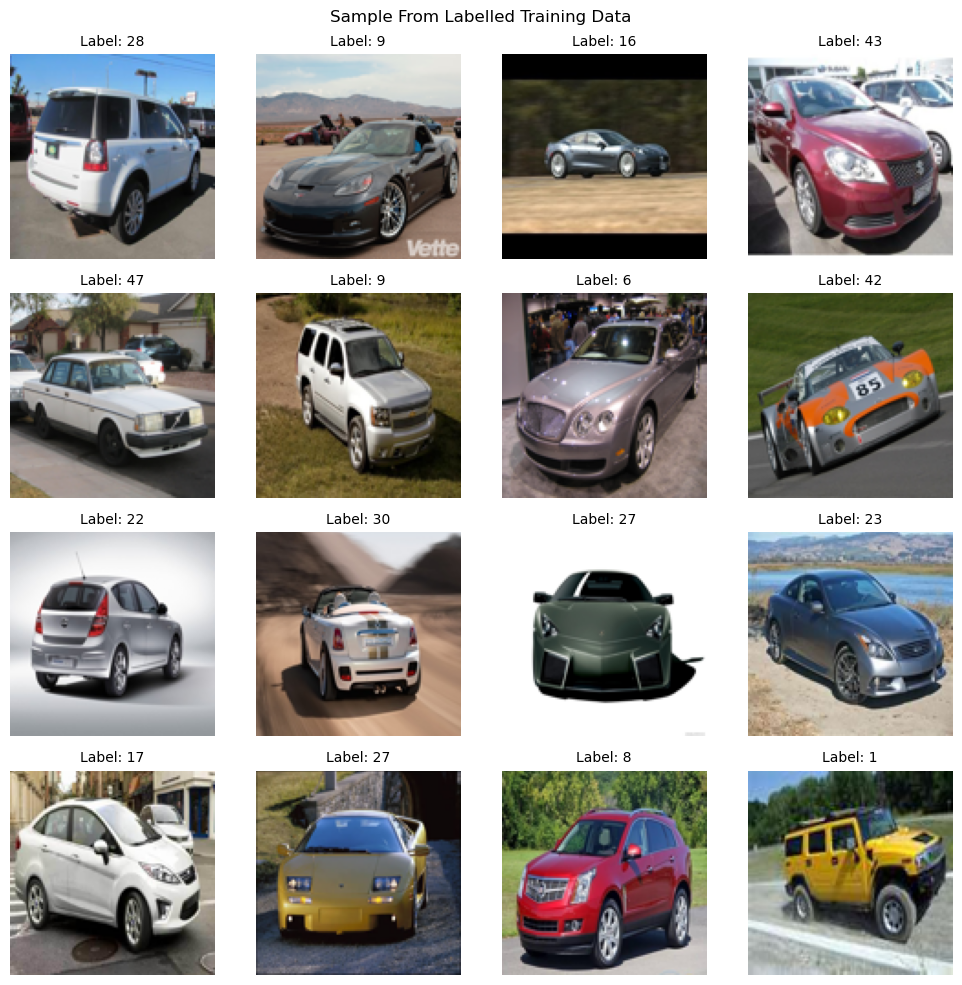

In [5]:
for images, labels in train_loader:
    break 

# Create figure
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(16):
    img = images[i].permute(1, 2, 0).numpy() 
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}", fontsize=10)
    axes[i].axis("off")

plt.suptitle("Sample From Labelled Training Data")
plt.tight_layout(rect=[0, 0, 1, 1]) 
plt.show()

### VGG Models

In [6]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x

In [32]:
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.layer1 = BasicBlock(3, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = BasicBlock(64, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = BasicBlock(128, 256)
        self.layer4 = BasicBlock(256, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = BasicBlock(256, 512)
        self.layer6 = BasicBlock(512, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer7 = BasicBlock(512, 512)
        self.layer8 = BasicBlock(512, 512)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(4608, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 48)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.maxpool1(x)
        x = self.layer2(x)
        x = self.maxpool2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.maxpool3(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.maxpool4(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### Training

In [31]:
def train_model(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
    
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels[:,0].to(device) - 1

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")
    
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels[:,0].to(device) - 1
            
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        print(f'Validation Acc: {val_acc:.4f}')

In [33]:
model = VGG11().to(device)
train_model(model)

100%|██████████| 179/179 [00:33<00:00,  5.30it/s]


Epoch 1/30 - Loss: 3.4860 - Accuracy: 0.0961
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.88it/s]


Epoch 2/30 - Loss: 3.4271 - Accuracy: 0.1118
Validation Acc: 0.1044


100%|██████████| 179/179 [01:07<00:00,  2.66it/s]


Epoch 3/30 - Loss: 3.4160 - Accuracy: 0.1105
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.94it/s]


Epoch 4/30 - Loss: 3.4166 - Accuracy: 0.1102
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.32it/s]


Epoch 5/30 - Loss: 3.4125 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.93it/s]


Epoch 6/30 - Loss: 3.4101 - Accuracy: 0.1121
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00,  9.95it/s]


Epoch 7/30 - Loss: 3.4086 - Accuracy: 0.1121
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.78it/s]


Epoch 8/30 - Loss: 3.4042 - Accuracy: 0.1116
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.88it/s]


Epoch 9/30 - Loss: 3.3923 - Accuracy: 0.1100
Validation Acc: 0.1050


100%|██████████| 179/179 [00:17<00:00, 10.01it/s]


Epoch 10/30 - Loss: 3.3628 - Accuracy: 0.1132
Validation Acc: 0.1038


100%|██████████| 179/179 [01:48<00:00,  1.65it/s]


Epoch 11/30 - Loss: 3.3300 - Accuracy: 0.1161
Validation Acc: 0.1069


100%|██████████| 179/179 [00:21<00:00,  8.47it/s]


Epoch 12/30 - Loss: 3.3200 - Accuracy: 0.1158
Validation Acc: 0.1069


100%|██████████| 179/179 [00:18<00:00,  9.77it/s]


Epoch 13/30 - Loss: 3.3163 - Accuracy: 0.1182
Validation Acc: 0.1075


100%|██████████| 179/179 [00:18<00:00,  9.89it/s]


Epoch 14/30 - Loss: 3.3126 - Accuracy: 0.1177
Validation Acc: 0.1063


100%|██████████| 179/179 [00:18<00:00,  9.56it/s]


Epoch 15/30 - Loss: 3.3081 - Accuracy: 0.1167
Validation Acc: 0.1057


100%|██████████| 179/179 [00:19<00:00,  9.37it/s]


Epoch 16/30 - Loss: 3.3045 - Accuracy: 0.1196
Validation Acc: 0.1081


100%|██████████| 179/179 [00:18<00:00,  9.94it/s]


Epoch 17/30 - Loss: 3.2986 - Accuracy: 0.1182
Validation Acc: 0.1075


100%|██████████| 179/179 [00:17<00:00,  9.95it/s]


Epoch 18/30 - Loss: 3.2886 - Accuracy: 0.1232
Validation Acc: 0.1093


100%|██████████| 179/179 [00:18<00:00,  9.78it/s]


Epoch 19/30 - Loss: 3.2830 - Accuracy: 0.1214
Validation Acc: 0.1106


100%|██████████| 179/179 [00:17<00:00, 10.06it/s]


Epoch 20/30 - Loss: 3.2758 - Accuracy: 0.1214
Validation Acc: 0.1069


100%|██████████| 179/179 [00:18<00:00,  9.81it/s]


Epoch 21/30 - Loss: 3.2672 - Accuracy: 0.1246
Validation Acc: 0.1149


100%|██████████| 179/179 [00:18<00:00,  9.72it/s]


Epoch 22/30 - Loss: 3.2649 - Accuracy: 0.1254
Validation Acc: 0.1186


100%|██████████| 179/179 [00:17<00:00, 10.11it/s]


Epoch 23/30 - Loss: 3.2661 - Accuracy: 0.1246
Validation Acc: 0.1179


100%|██████████| 179/179 [00:17<00:00, 10.05it/s]


Epoch 24/30 - Loss: 3.2632 - Accuracy: 0.1270
Validation Acc: 0.1167


100%|██████████| 179/179 [00:18<00:00,  9.88it/s]


Epoch 25/30 - Loss: 3.2621 - Accuracy: 0.1237
Validation Acc: 0.1167


100%|██████████| 179/179 [00:17<00:00, 10.00it/s]


Epoch 26/30 - Loss: 3.2622 - Accuracy: 0.1261
Validation Acc: 0.1167


100%|██████████| 179/179 [00:17<00:00, 10.10it/s]


Epoch 27/30 - Loss: 3.2625 - Accuracy: 0.1253
Validation Acc: 0.1198


100%|██████████| 179/179 [00:18<00:00,  9.72it/s]


Epoch 28/30 - Loss: 3.2624 - Accuracy: 0.1232
Validation Acc: 0.1186


100%|██████████| 179/179 [00:18<00:00,  9.67it/s]


Epoch 29/30 - Loss: 3.2597 - Accuracy: 0.1272
Validation Acc: 0.1204


100%|██████████| 179/179 [00:18<00:00,  9.61it/s]


Epoch 30/30 - Loss: 3.2584 - Accuracy: 0.1258
Validation Acc: 0.1192


In [34]:
torch.save(model.state_dict(), "VGG11")

### Testing

In [35]:
def test_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels[:,0].to(device) - 1 
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Concatenate all predictions and labels if needed for further analysis
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    return accuracy, all_preds, all_labels

In [36]:
test_model(model, test_loader, device)

Test Accuracy: 0.1103


(0.11029411764705882,
 tensor([ 8,  8,  8,  8,  8,  3,  8,  3,  8,  3,  8,  8, 26,  3,  3,  8,  8,  8,
          8,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  3,  3,  3,  8,  3,
         26,  8,  8,  3,  3,  8,  8,  3,  3,  8,  8,  3,  8,  8, 26,  8,  3,  3,
          3,  8,  8,  8,  8,  8,  8,  3, 26,  8,  3,  3,  8,  3,  3,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  3,  3,  8,  8,  8,  8,  8,  8,  8,  3,  8,  3,
          4,  8,  8,  8,  8,  8,  3,  8,  8,  3,  4, 11,  8,  8,  3,  3, 26,  8,
          3,  8,  8,  8,  8,  3,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  3,  8,
          8, 26,  8,  8,  8,  8,  8, 26,  8,  3, 26,  8,  8,  3,  8,  8,  8,  3,
          8,  8,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  3,  4, 11,  8,  4, 26,
          3, 26,  8,  8, 26,  8,  8,  8,  3,  8,  8,  8,  8,  8, 26,  8,  8,  3,
          8,  8,  3,  8,  8,  3, 26,  3,  3,  8,  8,  8,  4,  8,  8,  8,  3,  8,
          3,  8,  8,  8, 26,  3,  8,  3,  8,  8,  8,  8,  8,  8,  3,  8,  8,  8,
      

In [37]:
class VGG13(nn.Module):
    def __init__(self):
        super(VGG13, self).__init__()
        self.layer1 = BasicBlock(3, 64)
        self.layer11 = BasicBlock(64, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = BasicBlock(64, 128)
        self.layer22 = BasicBlock(128, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = BasicBlock(128, 256)
        self.layer4 = BasicBlock(256, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = BasicBlock(256, 512)
        self.layer6 = BasicBlock(512, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer7 = BasicBlock(512, 512)
        self.layer8 = BasicBlock(512, 512)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(4608, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 48)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer11(x)
        x = self.maxpool1(x)
        x = self.layer2(x)
        x = self.layer22(x)
        x = self.maxpool2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.maxpool3(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.maxpool4(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [38]:
model = VGG13().to(device)
train_model(model)

100%|██████████| 179/179 [00:18<00:00,  9.88it/s]


Epoch 1/30 - Loss: 3.4675 - Accuracy: 0.1040
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00,  9.99it/s]


Epoch 2/30 - Loss: 3.4283 - Accuracy: 0.1119
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.50it/s]


Epoch 3/30 - Loss: 3.4181 - Accuracy: 0.1074
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.94it/s]


Epoch 4/30 - Loss: 3.4148 - Accuracy: 0.1105
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00,  9.99it/s]


Epoch 5/30 - Loss: 3.4106 - Accuracy: 0.1118
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00, 10.05it/s]


Epoch 6/30 - Loss: 3.4110 - Accuracy: 0.1114
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00,  9.95it/s]


Epoch 7/30 - Loss: 3.4140 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.38it/s]


Epoch 8/30 - Loss: 3.4127 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.28it/s]


Epoch 9/30 - Loss: 3.4116 - Accuracy: 0.1139
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00, 10.10it/s]


Epoch 10/30 - Loss: 3.4137 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00, 10.04it/s]


Epoch 11/30 - Loss: 3.4085 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00,  9.99it/s]


Epoch 12/30 - Loss: 3.4056 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00, 10.05it/s]


Epoch 13/30 - Loss: 3.4067 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.92it/s]


Epoch 14/30 - Loss: 3.4041 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.88it/s]


Epoch 15/30 - Loss: 3.4049 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00, 10.05it/s]


Epoch 16/30 - Loss: 3.4063 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.73it/s]


Epoch 17/30 - Loss: 3.4051 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.83it/s]


Epoch 18/30 - Loss: 3.4027 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00,  9.99it/s]


Epoch 19/30 - Loss: 3.4050 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.88it/s]


Epoch 20/30 - Loss: 3.4050 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.57it/s]


Epoch 21/30 - Loss: 3.4046 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00, 10.11it/s]


Epoch 22/30 - Loss: 3.4040 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.72it/s]


Epoch 23/30 - Loss: 3.4039 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.94it/s]


Epoch 24/30 - Loss: 3.4035 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00,  9.95it/s]


Epoch 25/30 - Loss: 3.4039 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.67it/s]


Epoch 26/30 - Loss: 3.4039 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.60it/s]


Epoch 27/30 - Loss: 3.4032 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00, 10.00it/s]


Epoch 28/30 - Loss: 3.4046 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00,  9.98it/s]


Epoch 29/30 - Loss: 3.4040 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.89it/s]


Epoch 30/30 - Loss: 3.4008 - Accuracy: 0.1123
Validation Acc: 0.1044


In [39]:
torch.save(model.state_dict(), "VGG13")

In [40]:
test_model(model, test_loader, device)

Test Accuracy: 0.1164


(0.11642156862745098,
 tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
      

In [41]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.layer1 = BasicBlock(3, 64)
        self.layer11 = BasicBlock(64, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = BasicBlock(64, 128)
        self.layer22 = BasicBlock(128, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = BasicBlock(128, 256)
        self.layer4 = BasicBlock(256, 256)
        self.layer41 = BasicBlock(256, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = BasicBlock(256, 512)
        self.layer6 = BasicBlock(512, 512)
        self.layer61 = BasicBlock(512, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer7 = BasicBlock(512, 512)
        self.layer8 = BasicBlock(512, 512)
        self.layer81 = BasicBlock(512, 512)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(4608, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 48)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer11(x)
        x = self.maxpool1(x)
        x = self.layer2(x)
        x = self.layer22(x)
        x = self.maxpool2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer41(x)
        x = self.maxpool3(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer61(x)
        x = self.maxpool4(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer81(x)
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [42]:
model = VGG16().to(device)
train_model(model)

100%|██████████| 179/179 [00:18<00:00,  9.87it/s]


Epoch 1/30 - Loss: 3.4668 - Accuracy: 0.1044
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.46it/s]


Epoch 2/30 - Loss: 3.4304 - Accuracy: 0.1105
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.23it/s]


Epoch 3/30 - Loss: 3.4197 - Accuracy: 0.1121
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.73it/s]


Epoch 4/30 - Loss: 3.4198 - Accuracy: 0.1119
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.52it/s]


Epoch 5/30 - Loss: 3.4174 - Accuracy: 0.1118
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.66it/s]


Epoch 6/30 - Loss: 3.4215 - Accuracy: 0.1118
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.62it/s]


Epoch 7/30 - Loss: 3.4165 - Accuracy: 0.1121
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.61it/s]


Epoch 8/30 - Loss: 3.4161 - Accuracy: 0.1109
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.36it/s]


Epoch 9/30 - Loss: 3.4127 - Accuracy: 0.1121
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.31it/s]


Epoch 10/30 - Loss: 3.4117 - Accuracy: 0.1119
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.34it/s]


Epoch 11/30 - Loss: 3.4070 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.72it/s]


Epoch 12/30 - Loss: 3.4070 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.76it/s]


Epoch 13/30 - Loss: 3.4045 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.92it/s]


Epoch 14/30 - Loss: 3.4053 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.82it/s]


Epoch 15/30 - Loss: 3.4055 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.13it/s]


Epoch 16/30 - Loss: 3.4064 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00,  9.95it/s]


Epoch 17/30 - Loss: 3.4045 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.72it/s]


Epoch 18/30 - Loss: 3.4050 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.40it/s]


Epoch 19/30 - Loss: 3.4059 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.73it/s]


Epoch 20/30 - Loss: 3.4032 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.37it/s]


Epoch 21/30 - Loss: 3.4040 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:17<00:00,  9.97it/s]


Epoch 22/30 - Loss: 3.4024 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.94it/s]


Epoch 23/30 - Loss: 3.4045 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.66it/s]


Epoch 24/30 - Loss: 3.4042 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.93it/s]


Epoch 25/30 - Loss: 3.4053 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:20<00:00,  8.91it/s]


Epoch 26/30 - Loss: 3.4044 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.66it/s]


Epoch 27/30 - Loss: 3.4048 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.37it/s]


Epoch 28/30 - Loss: 3.4051 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.61it/s]


Epoch 29/30 - Loss: 3.4036 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.56it/s]


Epoch 30/30 - Loss: 3.4034 - Accuracy: 0.1123
Validation Acc: 0.1044


In [43]:
torch.save(model.state_dict(), "VGG16")

In [44]:
test_model(model, test_loader, device)

Test Accuracy: 0.1164


(0.11642156862745098,
 tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
      

In [45]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        self.layer1 = BasicBlock(3, 64)
        self.layer11 = BasicBlock(64, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = BasicBlock(64, 128)
        self.layer22 = BasicBlock(128, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = BasicBlock(128, 256)
        self.layer4 = BasicBlock(256, 256)
        self.layer41 = BasicBlock(256, 256)
        self.layer42 = BasicBlock(256, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = BasicBlock(256, 512)
        self.layer6 = BasicBlock(512, 512)
        self.layer61 = BasicBlock(512, 512)
        self.layer62 = BasicBlock(512, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer7 = BasicBlock(512, 512)
        self.layer8 = BasicBlock(512, 512)
        self.layer81 = BasicBlock(512, 512)
        self.layer82 = BasicBlock(512, 512)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(4608, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 48)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer11(x)
        x = self.maxpool1(x)
        x = self.layer2(x)
        x = self.layer22(x)
        x = self.maxpool2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer41(x)
        x = self.layer42(x)
        x = self.maxpool3(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer61(x)
        x = self.layer62(x)
        x = self.maxpool4(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer81(x)
        x = self.layer82(x)
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [46]:
model = VGG19().to(device)
train_model(model)

100%|██████████| 179/179 [00:19<00:00,  9.18it/s]


Epoch 1/30 - Loss: 3.4852 - Accuracy: 0.1049
Validation Acc: 0.0762


100%|██████████| 179/179 [00:18<00:00,  9.93it/s]


Epoch 2/30 - Loss: 3.4206 - Accuracy: 0.1068
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.56it/s]


Epoch 3/30 - Loss: 3.4227 - Accuracy: 0.1119
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.67it/s]


Epoch 4/30 - Loss: 3.4168 - Accuracy: 0.1114
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.54it/s]


Epoch 5/30 - Loss: 3.4135 - Accuracy: 0.1109
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.66it/s]


Epoch 6/30 - Loss: 3.4142 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.36it/s]


Epoch 7/30 - Loss: 3.4141 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.37it/s]


Epoch 8/30 - Loss: 3.4142 - Accuracy: 0.1119
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.62it/s]


Epoch 9/30 - Loss: 3.4150 - Accuracy: 0.1119
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.46it/s]


Epoch 10/30 - Loss: 3.4124 - Accuracy: 0.1121
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.05it/s]


Epoch 11/30 - Loss: 3.4063 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.18it/s]


Epoch 12/30 - Loss: 3.4062 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:20<00:00,  8.64it/s]


Epoch 13/30 - Loss: 3.4053 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.17it/s]


Epoch 14/30 - Loss: 3.4064 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.89it/s]


Epoch 15/30 - Loss: 3.4045 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.37it/s]


Epoch 16/30 - Loss: 3.4054 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.08it/s]


Epoch 17/30 - Loss: 3.4039 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.36it/s]


Epoch 18/30 - Loss: 3.4046 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.08it/s]


Epoch 19/30 - Loss: 3.4037 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.37it/s]


Epoch 20/30 - Loss: 3.4049 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.27it/s]


Epoch 21/30 - Loss: 3.4035 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.57it/s]


Epoch 22/30 - Loss: 3.4060 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.57it/s]


Epoch 23/30 - Loss: 3.4057 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:18<00:00,  9.46it/s]


Epoch 24/30 - Loss: 3.4053 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:20<00:00,  8.77it/s]


Epoch 25/30 - Loss: 3.4042 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.32it/s]


Epoch 26/30 - Loss: 3.4044 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.08it/s]


Epoch 27/30 - Loss: 3.4042 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.32it/s]


Epoch 28/30 - Loss: 3.4037 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.13it/s]


Epoch 29/30 - Loss: 3.4041 - Accuracy: 0.1123
Validation Acc: 0.1044


100%|██████████| 179/179 [00:19<00:00,  9.13it/s]


Epoch 30/30 - Loss: 3.4030 - Accuracy: 0.1123
Validation Acc: 0.1044


In [47]:
torch.save(model.state_dict(), "VGG19")

In [48]:
test_model(model, test_loader, device)

Test Accuracy: 0.1164


(0.11642156862745098,
 tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
      

### Pre-trained VGG models

In [49]:
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        # self.layer1 = BasicBlock(3, 112)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer2 = BasicBlock(112, 128)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer3 = BasicBlock(128, 256)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        # self.layer4 = BasicBlock(256, 256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer5 = BasicBlock(256, 512)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        # self.layer6 = BasicBlock(512, 512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu6 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer7 = BasicBlock(512, 512)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu7 = nn.ReLU()
        # self.layer8 = BasicBlock(512, 512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu8 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(4608, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 48)
        )
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.maxpool1(x)
        x = self.relu2(self.conv2(x))
        x = self.maxpool2(x)
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.maxpool3(x)
        x = self.relu5(self.conv5(x))
        x = self.relu6(self.conv6(x))
        x = self.maxpool4(x)
        x = self.relu7(self.conv7(x))
        x = self.relu8(self.conv8(x))
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def copy_params_from_vgg11(self, vgg11):
        features = [
            self.conv1, self.relu1,
            self.maxpool1,
            self.conv2, self.relu2,
            self.maxpool2,
            self.conv3, self.relu3,
            self.conv4, self.relu4,
            self.maxpool3,
            self.conv5, self.relu5,
            self.conv6, self.relu6,
            self.maxpool4,
            self.conv7, self.relu7,
            self.conv8, self.relu8,
            self.maxpool5,
        ]
        for l1, l2 in zip(vgg11.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                if l1.weight.size() == l2.weight.size():
                # assert l1.bias.size() == l2.bias.size()
                    l2.weight.data = l1.weight.data
                    l2.bias.data = l1.bias.data
        # for i, name in zip([0, 3], ['fc6', 'fc7']):
        #     l1 = vgg16.classifier[i]
        #     l2 = getattr(self, name)
        #     l2.weight.data = l1.weight.data.view(l2.weight.size())
        #     l2.bias.data = l1.bias.data.view(l2.bias.size())

In [50]:
from torchvision import models

vgg = models.vgg11(pretrained=True)

model_pretrain = VGG11()
model_pretrain.copy_params_from_vgg11(vgg)
model_pretrain.to(device)

train_model(model_pretrain)


# If you're using a newer torchvision version, use:
# vgg = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)

# num_classes = 48
# vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, num_classes)

100%|██████████| 179/179 [00:18<00:00,  9.76it/s]


Epoch 1/30 - Loss: 3.2678 - Accuracy: 0.1475
Validation Acc: 0.2156


100%|██████████| 179/179 [00:19<00:00,  9.23it/s]


Epoch 2/30 - Loss: 2.5801 - Accuracy: 0.3007
Validation Acc: 0.2893


100%|██████████| 179/179 [00:19<00:00,  9.41it/s]


Epoch 3/30 - Loss: 1.8319 - Accuracy: 0.4870
Validation Acc: 0.3986


100%|██████████| 179/179 [00:20<00:00,  8.91it/s]


Epoch 4/30 - Loss: 1.1611 - Accuracy: 0.6595
Validation Acc: 0.4656


100%|██████████| 179/179 [00:18<00:00,  9.62it/s]


Epoch 5/30 - Loss: 0.6464 - Accuracy: 0.8070
Validation Acc: 0.4650


100%|██████████| 179/179 [00:18<00:00,  9.77it/s]


Epoch 6/30 - Loss: 0.2897 - Accuracy: 0.9089
Validation Acc: 0.5123


100%|██████████| 179/179 [00:19<00:00,  9.09it/s]


Epoch 7/30 - Loss: 0.1717 - Accuracy: 0.9486
Validation Acc: 0.4865


100%|██████████| 179/179 [00:18<00:00,  9.83it/s]


Epoch 8/30 - Loss: 0.1369 - Accuracy: 0.9602
Validation Acc: 0.5086


100%|██████████| 179/179 [00:18<00:00,  9.52it/s]


Epoch 9/30 - Loss: 0.0813 - Accuracy: 0.9756
Validation Acc: 0.5178


100%|██████████| 179/179 [00:18<00:00,  9.62it/s]


Epoch 10/30 - Loss: 0.0735 - Accuracy: 0.9805
Validation Acc: 0.4975


100%|██████████| 179/179 [00:19<00:00,  9.32it/s]


Epoch 11/30 - Loss: 0.0207 - Accuracy: 0.9953
Validation Acc: 0.5473


100%|██████████| 179/179 [00:19<00:00,  9.27it/s]


Epoch 12/30 - Loss: 0.0083 - Accuracy: 0.9984
Validation Acc: 0.5356


100%|██████████| 179/179 [00:20<00:00,  8.90it/s]


Epoch 13/30 - Loss: 0.0039 - Accuracy: 0.9998
Validation Acc: 0.5436


100%|██████████| 179/179 [00:18<00:00,  9.51it/s]


Epoch 14/30 - Loss: 0.0034 - Accuracy: 0.9993
Validation Acc: 0.5467


100%|██████████| 179/179 [00:17<00:00,  9.99it/s]


Epoch 15/30 - Loss: 0.0031 - Accuracy: 1.0000
Validation Acc: 0.5534


100%|██████████| 179/179 [00:18<00:00,  9.83it/s]


Epoch 16/30 - Loss: 0.0021 - Accuracy: 1.0000
Validation Acc: 0.5577


100%|██████████| 179/179 [00:18<00:00,  9.83it/s]


Epoch 17/30 - Loss: 0.0018 - Accuracy: 0.9998
Validation Acc: 0.5559


100%|██████████| 179/179 [00:18<00:00,  9.43it/s]


Epoch 18/30 - Loss: 0.0020 - Accuracy: 0.9995
Validation Acc: 0.5467


100%|██████████| 179/179 [00:18<00:00,  9.83it/s]


Epoch 19/30 - Loss: 0.0018 - Accuracy: 0.9998
Validation Acc: 0.5491


100%|██████████| 179/179 [00:17<00:00, 10.16it/s]


Epoch 20/30 - Loss: 0.0016 - Accuracy: 0.9996
Validation Acc: 0.5467


100%|██████████| 179/179 [00:18<00:00,  9.89it/s]


Epoch 21/30 - Loss: 0.0012 - Accuracy: 0.9998
Validation Acc: 0.5430


100%|██████████| 179/179 [00:18<00:00,  9.68it/s]


Epoch 22/30 - Loss: 0.0017 - Accuracy: 0.9996
Validation Acc: 0.5461


100%|██████████| 179/179 [00:18<00:00,  9.90it/s]


Epoch 23/30 - Loss: 0.0009 - Accuracy: 1.0000
Validation Acc: 0.5479


100%|██████████| 179/179 [00:18<00:00,  9.57it/s]


Epoch 24/30 - Loss: 0.0014 - Accuracy: 0.9998
Validation Acc: 0.5467


100%|██████████| 179/179 [00:18<00:00,  9.78it/s]


Epoch 25/30 - Loss: 0.0007 - Accuracy: 1.0000
Validation Acc: 0.5461


100%|██████████| 179/179 [00:18<00:00,  9.77it/s]


Epoch 26/30 - Loss: 0.0010 - Accuracy: 1.0000
Validation Acc: 0.5510


100%|██████████| 179/179 [00:18<00:00,  9.78it/s]


Epoch 27/30 - Loss: 0.0010 - Accuracy: 0.9998
Validation Acc: 0.5491


100%|██████████| 179/179 [00:18<00:00,  9.74it/s]


Epoch 28/30 - Loss: 0.0008 - Accuracy: 1.0000
Validation Acc: 0.5504


100%|██████████| 179/179 [00:18<00:00,  9.73it/s]


Epoch 29/30 - Loss: 0.0007 - Accuracy: 1.0000
Validation Acc: 0.5510


100%|██████████| 179/179 [00:18<00:00,  9.94it/s]


Epoch 30/30 - Loss: 0.0008 - Accuracy: 1.0000
Validation Acc: 0.5491


In [51]:
torch.save(model.state_dict(), "VGG11-Pretrain")

In [52]:
test_model(model_pretrain, test_loader, device)

Test Accuracy: 0.5490


(0.5490196078431373,
 tensor([ 3, 16, 11,  8,  8, 43,  4, 33, 11, 12, 21, 11, 26, 22,  4,  8,  8, 11,
          8, 21,  6, 11,  8, 19,  8, 16,  8,  4, 26, 20,  9, 42, 14, 30, 20, 19,
         14, 20, 16,  2, 15, 21, 11, 25,  3,  3,  4, 42,  4, 25, 32,  3,  8, 39,
         33, 11, 11, 21, 42,  1, 19, 25,  8, 28, 21, 33, 33,  3, 21,  3, 12,  8,
         13, 11, 11, 36,  3, 27, 30, 25, 17, 16, 11,  8, 14, 44,  7,  8, 11, 11,
         39, 11, 24, 21,  8, 20,  8, 44, 11,  9,  1,  3, 35, 46,  4,  6,  8, 11,
         39,  1, 33, 44, 42, 16, 11,  3, 16, 11, 11, 11,  6,  4, 23, 14,  4, 21,
          5, 26, 20,  9,  9, 21, 16,  8, 44, 13, 14, 46,  8, 33,  3, 21, 17, 31,
         34,  2, 21, 34,  8,  4, 19,  8, 34, 24, 14,  8,  8,  2,  6, 16,  9, 18,
         38, 42, 35, 33,  4, 25,  8,  8, 34, 42,  7, 16, 21, 28, 16, 45, 13,  1,
          8,  5, 25,  8, 21,  6,  4, 11,  6, 41, 25,  4,  2, 33, 45, 20, 16, 43,
         17, 38,  4,  1,  3,  8, 45, 33,  1, 40,  4,  3, 22, 17, 36,  5, 16,  5,
       

In [55]:
class VGG13(nn.Module):
    def __init__(self):
        super(VGG13, self).__init__()
        # self.layer1 = BasicBlock(3, 64)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv11 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu11 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer2 = BasicBlock(64, 128)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu22 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer3 = BasicBlock(128, 256)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        # self.layer4 = BasicBlock(256, 256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer5 = BasicBlock(256, 512)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        # self.layer6 = BasicBlock(512, 512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu6 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer7 = BasicBlock(512, 512)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu7 = nn.ReLU()
        # self.layer8 = BasicBlock(512, 512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu8 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(4608, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 48)
        )
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu11(self.conv11(x))
        x = self.maxpool1(x)
        x = self.relu2(self.conv2(x))
        x = self.relu22(self.conv22(x))
        x = self.maxpool2(x)
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.maxpool3(x)
        x = self.relu5(self.conv5(x))
        x = self.relu6(self.conv6(x))
        x = self.maxpool4(x)
        x = self.relu7(self.conv7(x))
        x = self.relu8(self.conv8(x))
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def copy_params_from_vgg13(self, vgg13):
        features = [
            self.conv1, self.relu1,
            self.conv11, self.relu11,
            self.maxpool1,
            self.conv2, self.relu2,
            self.conv22, self.relu22,
            self.maxpool2,
            self.conv3, self.relu3,
            self.conv4, self.relu4,
            self.maxpool3,
            self.conv5, self.relu5,
            self.conv6, self.relu6,
            self.maxpool4,
            self.conv7, self.relu7,
            self.conv8, self.relu8,
            self.maxpool5,
        ]
        for l1, l2 in zip(vgg13.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                if l1.weight.size() == l2.weight.size():
                    l2.weight.data = l1.weight.data
                    l2.bias.data = l1.bias.data

In [56]:
from torchvision import models

vgg = models.vgg13(pretrained=True)

model_pretrain = VGG13()
model_pretrain.copy_params_from_vgg13(vgg)
model_pretrain.to(device)

train_model(model_pretrain)

100%|██████████| 179/179 [00:18<00:00,  9.84it/s]


Epoch 1/30 - Loss: 3.2913 - Accuracy: 0.1414
Validation Acc: 0.1843


100%|██████████| 179/179 [00:18<00:00,  9.46it/s]


Epoch 2/30 - Loss: 2.6582 - Accuracy: 0.2889
Validation Acc: 0.3163


100%|██████████| 179/179 [00:19<00:00,  9.38it/s]


Epoch 3/30 - Loss: 1.8704 - Accuracy: 0.4782
Validation Acc: 0.4281


100%|██████████| 179/179 [00:18<00:00,  9.50it/s]


Epoch 4/30 - Loss: 1.1208 - Accuracy: 0.6716
Validation Acc: 0.4613


100%|██████████| 179/179 [00:18<00:00,  9.53it/s]


Epoch 5/30 - Loss: 0.5720 - Accuracy: 0.8225
Validation Acc: 0.4816


100%|██████████| 179/179 [00:19<00:00,  9.37it/s]


Epoch 6/30 - Loss: 0.3332 - Accuracy: 0.9021
Validation Acc: 0.4601


100%|██████████| 179/179 [00:18<00:00,  9.94it/s]


Epoch 7/30 - Loss: 0.1772 - Accuracy: 0.9474
Validation Acc: 0.5252


100%|██████████| 179/179 [00:19<00:00,  9.09it/s]


Epoch 8/30 - Loss: 0.1040 - Accuracy: 0.9684
Validation Acc: 0.4736


100%|██████████| 179/179 [00:18<00:00,  9.53it/s]


Epoch 9/30 - Loss: 0.1355 - Accuracy: 0.9623
Validation Acc: 0.5147


100%|██████████| 179/179 [00:19<00:00,  9.35it/s]


Epoch 10/30 - Loss: 0.0895 - Accuracy: 0.9751
Validation Acc: 0.4883


100%|██████████| 179/179 [00:19<00:00,  9.37it/s]


Epoch 11/30 - Loss: 0.0218 - Accuracy: 0.9939
Validation Acc: 0.5387


100%|██████████| 179/179 [00:18<00:00,  9.67it/s]


Epoch 12/30 - Loss: 0.0074 - Accuracy: 0.9986
Validation Acc: 0.5436


100%|██████████| 179/179 [00:18<00:00,  9.83it/s]


Epoch 13/30 - Loss: 0.0041 - Accuracy: 0.9993
Validation Acc: 0.5467


100%|██████████| 179/179 [00:18<00:00,  9.83it/s]


Epoch 14/30 - Loss: 0.0024 - Accuracy: 0.9998
Validation Acc: 0.5467


100%|██████████| 179/179 [00:18<00:00,  9.89it/s]


Epoch 15/30 - Loss: 0.0020 - Accuracy: 1.0000
Validation Acc: 0.5510


100%|██████████| 179/179 [00:18<00:00,  9.83it/s]


Epoch 16/30 - Loss: 0.0014 - Accuracy: 1.0000
Validation Acc: 0.5522


100%|██████████| 179/179 [00:17<00:00,  9.98it/s]


Epoch 17/30 - Loss: 0.0017 - Accuracy: 0.9998
Validation Acc: 0.5442


100%|██████████| 179/179 [00:18<00:00,  9.62it/s]


Epoch 18/30 - Loss: 0.0010 - Accuracy: 1.0000
Validation Acc: 0.5534


100%|██████████| 179/179 [00:19<00:00,  9.04it/s]


Epoch 19/30 - Loss: 0.0010 - Accuracy: 0.9998
Validation Acc: 0.5553


100%|██████████| 179/179 [00:18<00:00,  9.62it/s]


Epoch 20/30 - Loss: 0.0009 - Accuracy: 0.9998
Validation Acc: 0.5571


100%|██████████| 179/179 [00:18<00:00,  9.81it/s]


Epoch 21/30 - Loss: 0.0007 - Accuracy: 1.0000
Validation Acc: 0.5577


100%|██████████| 179/179 [00:18<00:00,  9.66it/s]


Epoch 22/30 - Loss: 0.0009 - Accuracy: 1.0000
Validation Acc: 0.5577


100%|██████████| 179/179 [00:18<00:00,  9.58it/s]


Epoch 23/30 - Loss: 0.0006 - Accuracy: 1.0000
Validation Acc: 0.5577


100%|██████████| 179/179 [00:18<00:00,  9.87it/s]


Epoch 24/30 - Loss: 0.0009 - Accuracy: 0.9998
Validation Acc: 0.5571


100%|██████████| 179/179 [00:18<00:00,  9.88it/s]


Epoch 25/30 - Loss: 0.0017 - Accuracy: 0.9995
Validation Acc: 0.5620


100%|██████████| 179/179 [00:18<00:00,  9.82it/s]


Epoch 26/30 - Loss: 0.0006 - Accuracy: 1.0000
Validation Acc: 0.5596


100%|██████████| 179/179 [00:18<00:00,  9.42it/s]


Epoch 27/30 - Loss: 0.0008 - Accuracy: 1.0000
Validation Acc: 0.5614


100%|██████████| 179/179 [00:18<00:00,  9.55it/s]


Epoch 28/30 - Loss: 0.0012 - Accuracy: 0.9996
Validation Acc: 0.5571


100%|██████████| 179/179 [00:18<00:00,  9.82it/s]


Epoch 29/30 - Loss: 0.0008 - Accuracy: 1.0000
Validation Acc: 0.5577


100%|██████████| 179/179 [00:17<00:00,  9.99it/s]


Epoch 30/30 - Loss: 0.0009 - Accuracy: 0.9998
Validation Acc: 0.5559


In [57]:
torch.save(model.state_dict(), "VGG13-Pretrain")

In [58]:
test_model(model_pretrain, test_loader, device)

Test Accuracy: 0.5613


(0.5612745098039216,
 tensor([ 3, 16, 11, 10,  8, 43,  4, 46, 11, 11,  6, 11, 26,  4,  4,  8,  8, 11,
          8, 21,  4, 11,  8, 19,  8, 16,  8,  5, 26, 20,  9,  8, 14,  4, 21, 19,
         14, 22, 16,  2, 43, 21, 11, 25,  3,  3,  4, 30,  4, 25, 32, 25, 16, 30,
          3, 17, 21, 44, 42,  1, 19, 25,  8, 45, 21, 33, 33,  3, 21,  3,  6,  8,
         13, 11, 11, 35,  3,  8, 30, 25,  8,  8, 17,  8, 14, 44,  7,  8, 42, 11,
         39, 11,  8, 43,  8, 21,  8, 44, 11, 35,  4, 10, 11,  4, 34, 21,  8, 38,
         30, 20, 16, 44,  7, 16, 33,  3,  8, 11, 42, 11,  5,  8, 44, 14,  4, 21,
          5, 26, 20,  9, 20, 21, 16,  8, 21, 13, 14, 46,  8, 33,  3, 21,  7, 44,
          8,  2, 21, 21,  8,  4, 19, 11, 35, 24, 14, 35, 35,  2, 37,  8, 11, 18,
          7,  4, 45, 33,  4, 25,  8, 16,  8, 40,  9,  7, 21,  3, 11, 20, 13,  6,
          8,  5, 19,  7, 21,  6,  4, 11,  6,  8, 25,  4,  3, 33, 45, 20, 12, 34,
          8, 38,  4,  1,  3,  8,  8, 33,  1, 17,  4,  3,  9, 17, 16,  5, 16,  5,
       

In [59]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # self.layer1 = BasicBlock(3, 64)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv11 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu11 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer2 = BasicBlock(64, 128)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu22 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer3 = BasicBlock(128, 256)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        # self.layer4 = BasicBlock(256, 256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.conv44 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu44 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer5 = BasicBlock(256, 512)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        # self.layer6 = BasicBlock(512, 512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu6 = nn.ReLU()
        self.conv66 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu66 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer7 = BasicBlock(512, 512)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu7 = nn.ReLU()
        # self.layer8 = BasicBlock(512, 512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu8 = nn.ReLU()
        self.conv88 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu88 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(4608, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 48)
        )
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu11(self.conv11(x))
        x = self.maxpool1(x)
        x = self.relu2(self.conv2(x))
        x = self.relu22(self.conv22(x))
        x = self.maxpool2(x)
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.relu44(self.conv44(x))
        x = self.maxpool3(x)
        x = self.relu5(self.conv5(x))
        x = self.relu6(self.conv6(x))
        x = self.relu66(self.conv66(x))
        x = self.maxpool4(x)
        x = self.relu7(self.conv7(x))
        x = self.relu8(self.conv8(x))
        x = self.relu88(self.conv88(x))
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1, self.relu1,
            self.conv11, self.relu11,
            self.maxpool1,
            self.conv2, self.relu2,
            self.conv22, self.relu22,
            self.maxpool2,
            self.conv3, self.relu3,
            self.conv4, self.relu4,
            self.conv44, self.relu44,
            self.maxpool3,
            self.conv5, self.relu5,
            self.conv6, self.relu6,
            self.conv66, self.relu66,
            self.maxpool4,
            self.conv7, self.relu7,
            self.conv8, self.relu8,
            self.conv88, self.relu88,
            self.maxpool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                if l1.weight.size() == l2.weight.size():
                    l2.weight.data = l1.weight.data
                    l2.bias.data = l1.bias.data

In [60]:
from torchvision import models

vgg = models.vgg16(pretrained=True)

model_pretrain = VGG16()
model_pretrain.copy_params_from_vgg16(vgg)
model_pretrain.to(device)

train_model(model_pretrain)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 179/179 [00:18<00:00,  9.92it/s]


Epoch 1/30 - Loss: 3.3280 - Accuracy: 0.1330
Validation Acc: 0.2095


100%|██████████| 179/179 [00:18<00:00,  9.93it/s]


Epoch 2/30 - Loss: 2.6987 - Accuracy: 0.2839
Validation Acc: 0.3188


100%|██████████| 179/179 [00:18<00:00,  9.48it/s]


Epoch 3/30 - Loss: 2.0249 - Accuracy: 0.4353
Validation Acc: 0.3477


100%|██████████| 179/179 [00:19<00:00,  9.17it/s]


Epoch 4/30 - Loss: 1.4172 - Accuracy: 0.5904
Validation Acc: 0.4496


100%|██████████| 179/179 [00:19<00:00,  8.99it/s]


Epoch 5/30 - Loss: 0.9845 - Accuracy: 0.7012
Validation Acc: 0.5129


100%|██████████| 179/179 [00:18<00:00,  9.48it/s]


Epoch 6/30 - Loss: 0.6756 - Accuracy: 0.7914
Validation Acc: 0.5104


100%|██████████| 179/179 [00:19<00:00,  9.31it/s]


Epoch 7/30 - Loss: 0.4467 - Accuracy: 0.8632
Validation Acc: 0.5639


100%|██████████| 179/179 [00:18<00:00,  9.69it/s]


Epoch 8/30 - Loss: 0.3071 - Accuracy: 0.9065
Validation Acc: 0.5977


100%|██████████| 179/179 [00:18<00:00,  9.75it/s]


Epoch 9/30 - Loss: 0.1838 - Accuracy: 0.9418
Validation Acc: 0.6050


100%|██████████| 179/179 [00:18<00:00,  9.85it/s]


Epoch 10/30 - Loss: 0.1191 - Accuracy: 0.9625
Validation Acc: 0.5860


100%|██████████| 179/179 [00:18<00:00,  9.63it/s]


Epoch 11/30 - Loss: 0.0303 - Accuracy: 0.9912
Validation Acc: 0.6296


100%|██████████| 179/179 [00:18<00:00,  9.61it/s]


Epoch 12/30 - Loss: 0.0101 - Accuracy: 0.9979
Validation Acc: 0.6339


100%|██████████| 179/179 [00:18<00:00,  9.47it/s]


Epoch 13/30 - Loss: 0.0058 - Accuracy: 0.9988
Validation Acc: 0.6357


100%|██████████| 179/179 [00:18<00:00,  9.60it/s]


Epoch 14/30 - Loss: 0.0043 - Accuracy: 0.9993
Validation Acc: 0.6351


100%|██████████| 179/179 [00:18<00:00,  9.63it/s]


Epoch 15/30 - Loss: 0.0029 - Accuracy: 1.0000
Validation Acc: 0.6394


100%|██████████| 179/179 [00:18<00:00,  9.47it/s]


Epoch 16/30 - Loss: 0.0027 - Accuracy: 0.9996
Validation Acc: 0.6333


100%|██████████| 179/179 [00:19<00:00,  9.36it/s]


Epoch 17/30 - Loss: 0.0021 - Accuracy: 0.9996
Validation Acc: 0.6413


100%|██████████| 179/179 [00:18<00:00,  9.83it/s]


Epoch 18/30 - Loss: 0.0023 - Accuracy: 0.9996
Validation Acc: 0.6370


100%|██████████| 179/179 [00:18<00:00,  9.62it/s]


Epoch 19/30 - Loss: 0.0016 - Accuracy: 0.9998
Validation Acc: 0.6400


100%|██████████| 179/179 [00:18<00:00,  9.78it/s]


Epoch 20/30 - Loss: 0.0015 - Accuracy: 0.9998
Validation Acc: 0.6357


100%|██████████| 179/179 [00:19<00:00,  9.39it/s]


Epoch 21/30 - Loss: 0.0009 - Accuracy: 1.0000
Validation Acc: 0.6364


100%|██████████| 179/179 [00:18<00:00,  9.52it/s]


Epoch 22/30 - Loss: 0.0007 - Accuracy: 1.0000
Validation Acc: 0.6364


100%|██████████| 179/179 [00:19<00:00,  9.37it/s]


Epoch 23/30 - Loss: 0.0009 - Accuracy: 1.0000
Validation Acc: 0.6370


100%|██████████| 179/179 [00:19<00:00,  9.35it/s]


Epoch 24/30 - Loss: 0.0011 - Accuracy: 0.9998
Validation Acc: 0.6382


100%|██████████| 179/179 [00:18<00:00,  9.59it/s]


Epoch 25/30 - Loss: 0.0007 - Accuracy: 1.0000
Validation Acc: 0.6364


100%|██████████| 179/179 [00:19<00:00,  9.17it/s]


Epoch 26/30 - Loss: 0.0008 - Accuracy: 0.9998
Validation Acc: 0.6376


100%|██████████| 179/179 [00:18<00:00,  9.78it/s]


Epoch 27/30 - Loss: 0.0007 - Accuracy: 1.0000
Validation Acc: 0.6388


100%|██████████| 179/179 [00:17<00:00, 10.00it/s]


Epoch 28/30 - Loss: 0.0008 - Accuracy: 1.0000
Validation Acc: 0.6376


100%|██████████| 179/179 [00:18<00:00,  9.57it/s]


Epoch 29/30 - Loss: 0.0010 - Accuracy: 0.9998
Validation Acc: 0.6364


100%|██████████| 179/179 [00:18<00:00,  9.75it/s]


Epoch 30/30 - Loss: 0.0007 - Accuracy: 1.0000
Validation Acc: 0.6382


In [61]:
torch.save(model.state_dict(), "VGG16-Pretrain")

In [62]:
test_model(model_pretrain, test_loader, device)

Test Accuracy: 0.6336


(0.633578431372549,
 tensor([ 3, 16, 11, 30,  8,  4, 42,  3, 11, 46, 21, 27, 26, 20,  4,  8,  8, 11,
          8, 21, 42, 11,  8,  8, 40, 16,  8,  4, 26, 20,  9,  8,  8,  4, 20, 16,
         14, 22, 16, 15, 15, 21, 11,  6,  3,  3,  4, 20, 20, 25, 32,  4, 30, 30,
          3, 17,  8, 40, 42,  8, 19, 25,  8, 42, 21, 33, 33,  3, 21,  3,  5,  8,
         13, 11,  1, 10,  3,  8, 30, 25,  8, 16, 23,  8, 14, 44,  7,  8, 16, 11,
         39, 11,  4, 22,  4,  1,  8, 44, 11,  2,  4, 45, 11, 46,  1,  6,  8, 11,
         30, 11,  8,  8, 45, 25, 33,  3, 44, 46, 16, 11,  2, 21,  7,  4,  4, 21,
          5, 26, 20, 16,  8, 21, 16, 11,  1, 45, 14, 46, 40, 33,  3, 21,  7, 31,
          8, 24, 21, 43,  8,  4, 19, 38, 35, 24, 16,  8, 16,  2,  6,  8,  9, 18,
         34,  4, 45, 33,  4, 25,  8,  8, 12, 42,  6,  7, 21,  3, 11, 45, 13,  1,
          8,  5, 25,  8, 21,  6,  4, 11,  6,  8, 25,  4,  3, 33, 45, 20,  1, 24,
          8, 38,  4,  1,  3,  8, 45, 34, 15, 40,  4,  3, 20, 44, 21,  5, 16,  5,
        

In [63]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        # self.layer1 = BasicBlock(3, 64)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv11 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu11 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer2 = BasicBlock(64, 128)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu22 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer3 = BasicBlock(128, 256)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        # self.layer4 = BasicBlock(256, 256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.conv44 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu44 = nn.ReLU()
        self.conv45 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu45 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer5 = BasicBlock(256, 512)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        # self.layer6 = BasicBlock(512, 512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu6 = nn.ReLU()
        self.conv66 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu66 = nn.ReLU()
        self.conv67 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu67 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.layer7 = BasicBlock(512, 512)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu7 = nn.ReLU()
        # self.layer8 = BasicBlock(512, 512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu8 = nn.ReLU()
        self.conv88 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu88 = nn.ReLU()
        self.conv89 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu89 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(4608, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 48)
        )
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu11(self.conv11(x))
        x = self.maxpool1(x)
        x = self.relu2(self.conv2(x))
        x = self.relu22(self.conv22(x))
        x = self.maxpool2(x)
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.relu44(self.conv44(x))
        x = self.relu45(self.conv45(x))
        x = self.maxpool3(x)
        x = self.relu5(self.conv5(x))
        x = self.relu6(self.conv6(x))
        x = self.relu66(self.conv66(x))
        x = self.relu67(self.conv67(x))
        x = self.maxpool4(x)
        x = self.relu7(self.conv7(x))
        x = self.relu8(self.conv8(x))
        x = self.relu88(self.conv88(x))
        x = self.relu89(self.conv89(x))
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def copy_params_from_vgg19(self, vgg19):
        features = [
            self.conv1, self.relu1,
            self.conv11, self.relu11,
            self.maxpool1,
            self.conv2, self.relu2,
            self.conv22, self.relu22,
            self.maxpool2,
            self.conv3, self.relu3,
            self.conv4, self.relu4,
            self.conv44, self.relu44,
            self.conv45, self.relu45,
            self.maxpool3,
            self.conv5, self.relu5,
            self.conv6, self.relu6,
            self.conv66, self.relu66,
            self.conv67, self.relu67,
            self.maxpool4,
            self.conv7, self.relu7,
            self.conv8, self.relu8,
            self.conv88, self.relu88,
            self.conv89, self.relu89,
            self.maxpool5,
        ]
        for l1, l2 in zip(vgg19.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                if l1.weight.size() == l2.weight.size():
                    l2.weight.data = l1.weight.data
                    l2.bias.data = l1.bias.data

In [64]:
from torchvision import models

vgg = models.vgg19(pretrained=True)

model_pretrain = VGG19()
model_pretrain.copy_params_from_vgg19(vgg)
model_pretrain.to(device)

train_model(model_pretrain)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/hgurusan/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 237MB/s] 
100%|██████████| 179/179 [00:18<00:00,  9.48it/s]


Epoch 1/30 - Loss: 3.3586 - Accuracy: 0.1346
Validation Acc: 0.1339


100%|██████████| 179/179 [00:19<00:00,  9.18it/s]


Epoch 2/30 - Loss: 2.9225 - Accuracy: 0.2196
Validation Acc: 0.2684


100%|██████████| 179/179 [00:19<00:00,  9.21it/s]


Epoch 3/30 - Loss: 2.3629 - Accuracy: 0.3430
Validation Acc: 0.3323


100%|██████████| 179/179 [00:19<00:00,  9.13it/s]


Epoch 4/30 - Loss: 1.8633 - Accuracy: 0.4637
Validation Acc: 0.4330


100%|██████████| 179/179 [00:19<00:00,  9.16it/s]


Epoch 5/30 - Loss: 1.4243 - Accuracy: 0.5860
Validation Acc: 0.4656


100%|██████████| 179/179 [00:20<00:00,  8.68it/s]


Epoch 6/30 - Loss: 1.0391 - Accuracy: 0.6795
Validation Acc: 0.5246


100%|██████████| 179/179 [00:19<00:00,  9.37it/s]


Epoch 7/30 - Loss: 0.8531 - Accuracy: 0.7389
Validation Acc: 0.4748


100%|██████████| 179/179 [00:19<00:00,  9.36it/s]


Epoch 8/30 - Loss: 0.5424 - Accuracy: 0.8318
Validation Acc: 0.5326


100%|██████████| 179/179 [00:19<00:00,  9.08it/s]


Epoch 9/30 - Loss: 0.4046 - Accuracy: 0.8730
Validation Acc: 0.5547


100%|██████████| 179/179 [00:19<00:00,  9.23it/s]


Epoch 10/30 - Loss: 0.3408 - Accuracy: 0.8907
Validation Acc: 0.5780


100%|██████████| 179/179 [00:19<00:00,  9.32it/s]


Epoch 11/30 - Loss: 0.0941 - Accuracy: 0.9733
Validation Acc: 0.6081


100%|██████████| 179/179 [00:19<00:00,  9.04it/s]


Epoch 12/30 - Loss: 0.0318 - Accuracy: 0.9928
Validation Acc: 0.6167


100%|██████████| 179/179 [00:18<00:00,  9.88it/s]


Epoch 13/30 - Loss: 0.0172 - Accuracy: 0.9974
Validation Acc: 0.6173


100%|██████████| 179/179 [00:18<00:00,  9.66it/s]


Epoch 14/30 - Loss: 0.0113 - Accuracy: 0.9986
Validation Acc: 0.6143


100%|██████████| 179/179 [00:18<00:00,  9.47it/s]


Epoch 15/30 - Loss: 0.0088 - Accuracy: 0.9986
Validation Acc: 0.6167


100%|██████████| 179/179 [00:19<00:00,  9.13it/s]


Epoch 16/30 - Loss: 0.0070 - Accuracy: 0.9988
Validation Acc: 0.6118


100%|██████████| 179/179 [00:20<00:00,  8.76it/s]


Epoch 17/30 - Loss: 0.0044 - Accuracy: 0.9998
Validation Acc: 0.6186


100%|██████████| 179/179 [00:19<00:00,  9.37it/s]


Epoch 18/30 - Loss: 0.0031 - Accuracy: 0.9996
Validation Acc: 0.6192


100%|██████████| 179/179 [00:19<00:00,  9.36it/s]


Epoch 19/30 - Loss: 0.0023 - Accuracy: 1.0000
Validation Acc: 0.6179


100%|██████████| 179/179 [00:19<00:00,  9.03it/s]


Epoch 20/30 - Loss: 0.0018 - Accuracy: 0.9998
Validation Acc: 0.6204


100%|██████████| 179/179 [00:19<00:00,  9.07it/s]


Epoch 21/30 - Loss: 0.0018 - Accuracy: 0.9996
Validation Acc: 0.6210


100%|██████████| 179/179 [00:19<00:00,  9.41it/s]


Epoch 22/30 - Loss: 0.0020 - Accuracy: 0.9996
Validation Acc: 0.6198


100%|██████████| 179/179 [00:19<00:00,  9.00it/s]


Epoch 23/30 - Loss: 0.0015 - Accuracy: 1.0000
Validation Acc: 0.6198


100%|██████████| 179/179 [00:19<00:00,  9.17it/s]


Epoch 24/30 - Loss: 0.0016 - Accuracy: 0.9996
Validation Acc: 0.6216


100%|██████████| 179/179 [00:20<00:00,  8.72it/s]


Epoch 25/30 - Loss: 0.0015 - Accuracy: 1.0000
Validation Acc: 0.6216


100%|██████████| 179/179 [00:19<00:00,  9.06it/s]


Epoch 26/30 - Loss: 0.0011 - Accuracy: 1.0000
Validation Acc: 0.6222


100%|██████████| 179/179 [00:20<00:00,  8.70it/s]


Epoch 27/30 - Loss: 0.0016 - Accuracy: 0.9998
Validation Acc: 0.6241


100%|██████████| 179/179 [00:20<00:00,  8.73it/s]


Epoch 28/30 - Loss: 0.0012 - Accuracy: 1.0000
Validation Acc: 0.6216


100%|██████████| 179/179 [00:19<00:00,  9.28it/s]


Epoch 29/30 - Loss: 0.0014 - Accuracy: 1.0000
Validation Acc: 0.6229


100%|██████████| 179/179 [00:18<00:00,  9.51it/s]


Epoch 30/30 - Loss: 0.0012 - Accuracy: 1.0000
Validation Acc: 0.6210


In [65]:
torch.save(model.state_dict(), "VGG19-Pretrain")

In [66]:
test_model(model_pretrain, test_loader, device)

Test Accuracy: 0.6385


(0.6384803921568627,
 tensor([ 3, 16, 11, 42, 17, 24,  4, 30, 11, 35, 21, 38,  3, 33,  4,  8,  8, 11,
         16, 21,  1, 11,  8,  8, 42, 16,  8,  4, 26, 44, 39,  8,  8,  4, 20, 19,
         14, 33, 16, 24, 15, 21, 11,  6,  3,  3,  4, 10, 45, 25, 32,  6, 30, 30,
          3, 17,  8, 44, 42, 11,  0, 25, 19,  8, 16, 33, 33, 33, 21,  3, 16,  8,
         45, 11, 24, 45,  3,  8, 30, 25,  8,  9, 17,  8, 14, 44,  7,  8, 10, 11,
         39, 11,  4, 37,  8,  1,  9, 44, 11, 14,  4, 10, 28, 46,  1,  6,  8, 38,
         35,  8, 38, 21, 22, 16, 11,  3, 23, 38, 11, 11,  7, 21, 17, 14,  4, 21,
          5, 32,  6,  9, 20, 21,  8,  8, 44, 45, 14, 10,  8, 33,  3, 20,  7, 38,
         35,  2, 21, 41,  8,  4, 19, 11, 35, 24, 14,  8,  8,  2, 34,  8,  9, 18,
          7,  4, 35, 33,  4, 25,  8,  8, 28, 42,  6, 35, 21,  3, 16, 42, 13,  1,
          8,  5, 19,  8, 21,  6, 43, 11,  6, 24, 25,  4, 12, 33, 45, 20,  1,  4,
         17, 11,  4,  1,  3,  8, 45, 22, 26, 31, 46,  3, 20, 38, 42,  5, 16,  5,
       